# Chapter 4

## Spatial autocorrelation

In [1]:
#import packages
import os

import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt 
import datetime as dt
import networkx as nx

from shapely.geometry import LineString, Point

import splot
import pysal
import libpysal
from libpysal import weights
from libpysal.weights import Kernel

from shapely.geometry import Point
from pysal.explore import esda
from esda.moran import Moran

from splot.esda import plot_moran, plot_local_autocorrelation, lisa_cluster
import matplotlib
import matplotlib.pyplot as plt 
import folium


import seaborn as sns

from sklearn.cluster import KMeans
from sklearn.cluster import dbscan



from splot.esda import moran_scatterplot
from esda.moran import Moran_Local
from splot.esda import lisa_cluster


libpysal.__version__

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
/Users/kultiginbozdemir/opt/anaconda3/envs/vytal/lib/python3.8/site-packages/spaghetti/network.py:36: FutureWarning: The next major release of pysal/spaghetti (2.0.0) will drop support for all ``libpysal.cg`` geometries. This change is a first step in refactoring ``spaghetti`` that is expected to result in dramatically reduced runtimes for network instantiation and operations. Users currently requiring network and point pattern input as ``libpysal.cg`` geometries should prepare for this simply by converting to ``shapely`` geometries.
  warnings.warn(f"{dep_msg}", FutureWarning)


'4.6.2'

<AxesSubplot:>

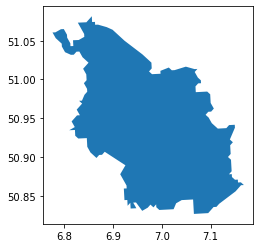

In [24]:
# Import map of German counties as geopandas file
boundaries = gpd.read_file('../data/DEU_adm/DEU_adm3.shp', encoding = "utf-8").set_crs(4326, allow_override=True)


#Take only Cologne
cologne=boundaries[boundaries["ID_3"]==289]
cologne.to_file("cologne.geojson", driver='GeoJSON')
cologne.plot()

In [3]:
%store -r vdf

## Pysal Moran's I Analysis

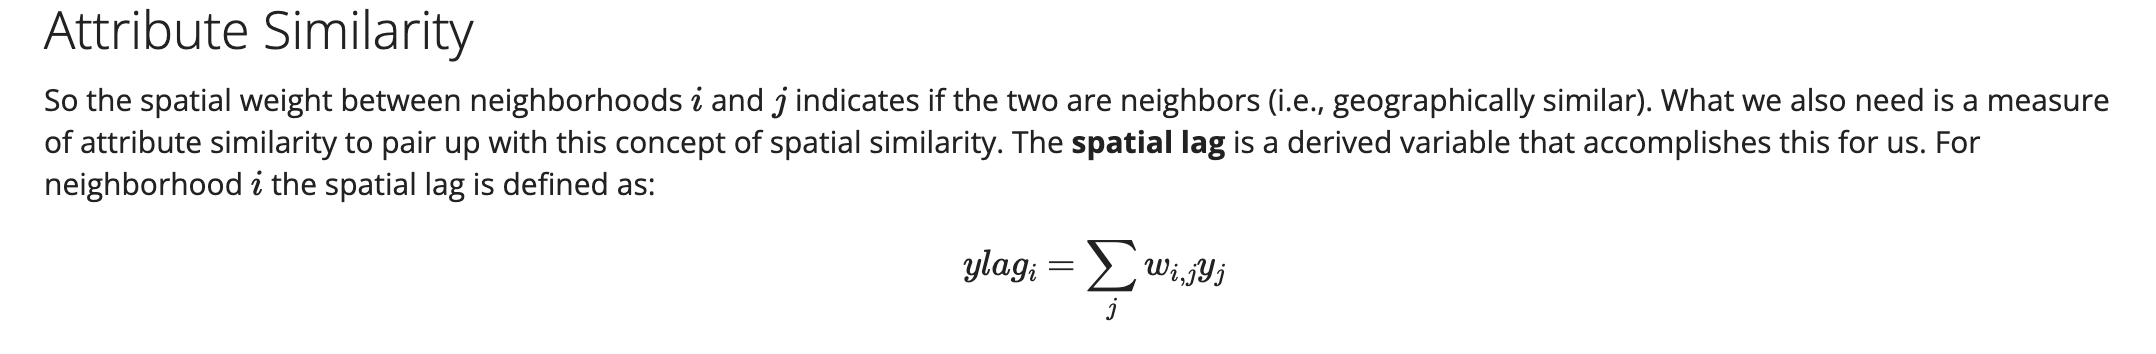

In [4]:
# I assume that 300 m is a plausible distance to lead consumers returning the containers to a nearby store.
bw=300
w = libpysal.weights.Kernel.from_dataframe(vdf, bandwidth=bw) # determine bw

vdf['total_degree']=vdf['in_degree']+vdf['out_degree']
y=vdf['total_degree']

w.transform = 'r'


# Sptial lag
ylag = libpysal.weights.lag_spatial(w, y)
#ylag

vdf['ylag'] = ylag
#vdf=vdf.drop(vdf[vdf['ylag']==0].index) # remove the islands
vdf.shape

(377, 26)

In [5]:
vdf['total_degree'].mean()

683.6074270557029

In [6]:

vdf['total_degree_log2']=np.log2(vdf['total_degree'])
vdf['ylag_log2']=np.log2(vdf['ylag'])
#vdf.head()

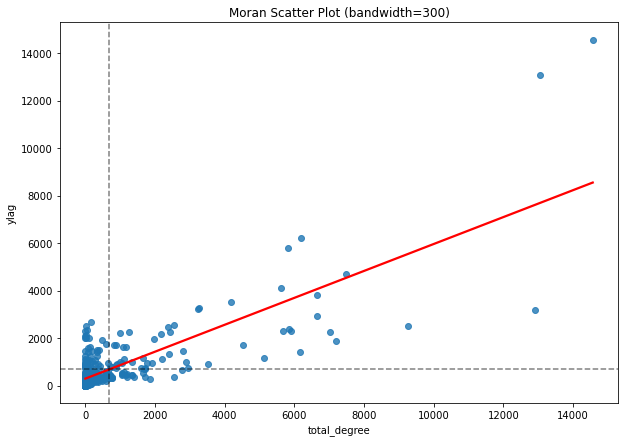

In [7]:
f, ax = plt.subplots(1, figsize=(10, 7))
sns.regplot(x='total_degree', y='ylag', 
                ci=None, data=vdf, line_kws={'color':'r'})
ax.axvline(vdf['total_degree'].mean(), c='k', ls='--', alpha=0.5)
ax.axhline(vdf['ylag'].mean(), c='k', ls='--',alpha=0.5)
ax.set_title('Moran Scatter Plot (bandwidth={})'.format(bw))
plt.show()

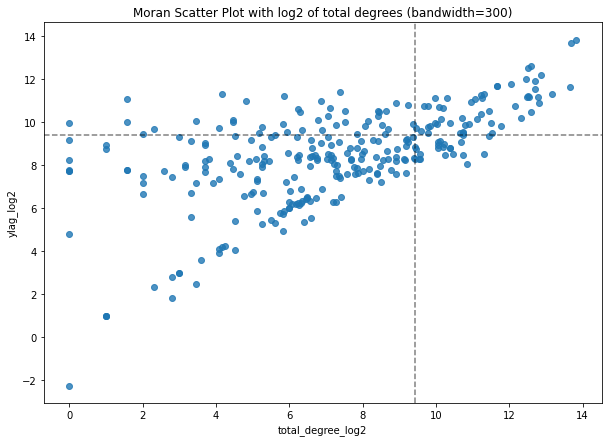

In [8]:
f, ax = plt.subplots(1, figsize=(10, 7))
sns.regplot(x='total_degree_log2', y='ylag_log2', 
                ci=None, data=vdf, line_kws={'color':'r'})
ax.axvline(np.log2(vdf['total_degree'].mean()), c='k',ls='--', alpha=0.5)
ax.axhline(np.log2(vdf['ylag'].mean()), c='k', ls='--',alpha=0.5)
ax.set_title('Moran Scatter Plot with log2 of total degrees (bandwidth={})'.format(bw))
plt.show()

In [9]:

moran = Moran(y, w)
moran.I

0.5666427930409801

In [10]:
# number of simulations; permutation test.
len(moran.sim)

999

In [11]:
moran.p_sim

0.033

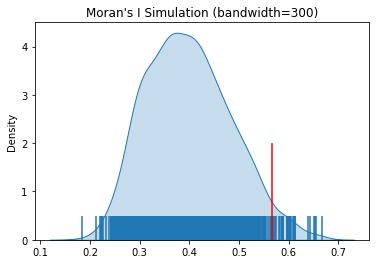

In [12]:
sns.kdeplot(moran.sim, shade=True)
plt.vlines(moran.sim, 0, 0.5)
plt.vlines(moran.I, 0, 2, 'r')
plt.title("Moran's I Simulation (bandwidth={})".format(bw))
#plt.xlim([-0.15, 0.55])
plt.show()

In [13]:
moran.p_sim

0.033

In [14]:
xdf=vdf.copy()

# Get Weights (Kernel)

w = libpysal.weights.Kernel.from_dataframe(xdf, bandwidth=300)


In [15]:
# remove inlands, stores that have no neigbours in 300m radius.
xdf2=xdf.drop([n[0] for n in list(w) if len(list(n[1]))<2])

In [16]:
y=xdf2['total_degree']


# Get Weights (Kernel)

w = libpysal.weights.Kernel.from_dataframe(xdf2, bandwidth=300)

w.transform = 'r'

# Sptial lag
ylag = weights.lag_spatial(w, y)
xdf2['ylag'] = ylag

In [17]:


# calculate Moran_Local and plot
moran_loc = Moran_Local(y, w)


In [18]:
pd.Series(moran_loc.p_sim<0.05).value_counts() # number of stores that have p_value<0.05

False    280
True      43
dtype: int64

In [19]:
xdf2['q']=moran_loc.q
#xdf2['q']

In [20]:
xdf2['p_sim']=moran_loc.p_sim
#xdf2['p_sim']

In [21]:
xdf2.loc[xdf2[xdf2['p_sim']>0.05].index,'q']=5

In [22]:
xdf2['q'].value_counts()

5    279
3     20
2     16
1      5
4      3
Name: q, dtype: int64

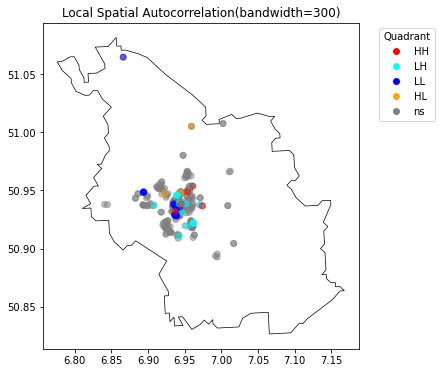

In [25]:
xdf2=xdf2.sort_values(by='q', ascending=False)

from matplotlib.lines import Line2D 
fig, ax = plt.subplots(figsize=(6, 6))
cologne.plot(ax=ax, facecolor="none", 
              edgecolor='black', lw=0.7)
colors = {1:'red', 2:'cyan', 3:'blue', 4:'orange',5:'grey'}
colors2 = {'HH':'red', 'LH':'cyan', 'LL':'blue', 'HL':'orange','ns':'grey'}
ax.scatter(xdf2['Longitude'], xdf2['Latitude'], c=xdf2['q'].map(colors), alpha=0.5)

handles = [Line2D([0], [0], marker='o', color='w', markerfacecolor=v, label=k, markersize=8) for k, v in colors2.items()]
ax.legend(title='Quadrant', handles=handles, bbox_to_anchor=(1.05, 1), loc='upper left')
plt.title('Local Spatial Autocorrelation(bandwidth={})'.format(bw))
plt.show()

In [26]:

xdf2['total_degree_log2']=np.log2(xdf2['total_degree'])
xdf2['ylag_log2']=np.log2(vdf['ylag'])

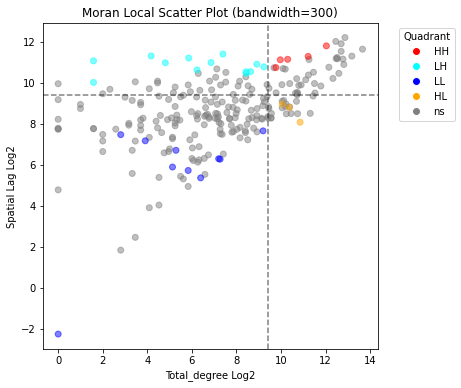

In [27]:
fig, ax = plt.subplots(figsize=(6, 6))

colors = {1:'red', 2:'cyan', 3:'blue', 4:'orange',5:'grey'}
colors2 = {'HH':'red', 'LH':'cyan', 'LL':'blue', 'HL':'orange','ns':'grey'}
ax.scatter(xdf2['total_degree_log2'], xdf2['ylag_log2'], c=xdf2['q'].map(colors), alpha=0.5)
ax.axvline(np.log2(vdf['total_degree'].mean()), c='k',ls='--', alpha=0.5)
ax.axhline(np.log2(vdf['ylag'].mean()), c='k', ls='--',alpha=0.5)
handles = [Line2D([0], [0], marker='o', color='w', markerfacecolor=v, label=k, markersize=8) for k, v in colors2.items()]
ax.legend(title='Quadrant', handles=handles, bbox_to_anchor=(1.05, 1), loc='upper left')
ax.set_title('Moran Local Scatter Plot (bandwidth={})'.format(bw))
plt.xlabel('Total_degree Log2')
plt.ylabel('Spatial Lag Log2')
plt.show()